In [40]:
import acoular as ac # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
from config import uma16_index
import h5py
from scipy.signal import butter, lfilter, welch # type: ignore

In [41]:
ac.config.global_caching = 'none'

In [45]:
folder = "uma16_example_recordings/"
hdf5_filename = folder + "450_and_700_1s_h5py.h5"

with h5py.File(hdf5_filename, 'r') as hdf5_file:
    signal = hdf5_file['data'][:]
    sample_freq = hdf5_file.attrs['sample_freq']
    channels = hdf5_file.attrs['channels']

print("Loaded signal shape:", signal.shape)
print("Sample freq:", sample_freq)
print("Number of channels:", channels)

fs = sample_freq #Abtastrate
t = np.arange(signal.shape[0]) / fs
df = 1/fs #Zeitabstand zwischen den Samples

Loaded signal shape: (44100, 16)
Sample freq: 44100.0
Number of channels: 16


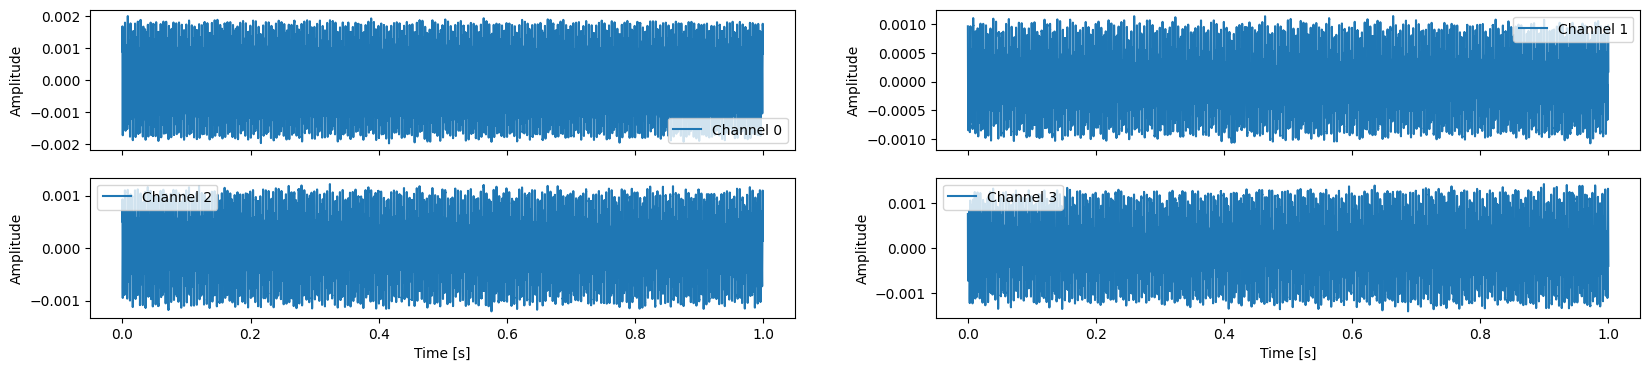

In [47]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(20,4))
for i in range(4):
    row = i // 2
    col = i % 2
    axs[row, col].plot(t, signal[:, i], label=f"Channel {i}")
    axs[row, col].set_ylabel("Amplitude")
    axs[row, col].legend()
axs[1, 0].set_xlabel("Time [s]")
axs[1, 1].set_xlabel("Time [s]")
plt.show()


In [48]:
freqs = np.fft.rfftfreq(signal.shape[0], d=df)
ind = np.searchsorted(freqs, 2500)
spectrum = np.fft.rfft(signal.T[0])
power_spectrum = np.real(spectrum * spectrum.conjugate())


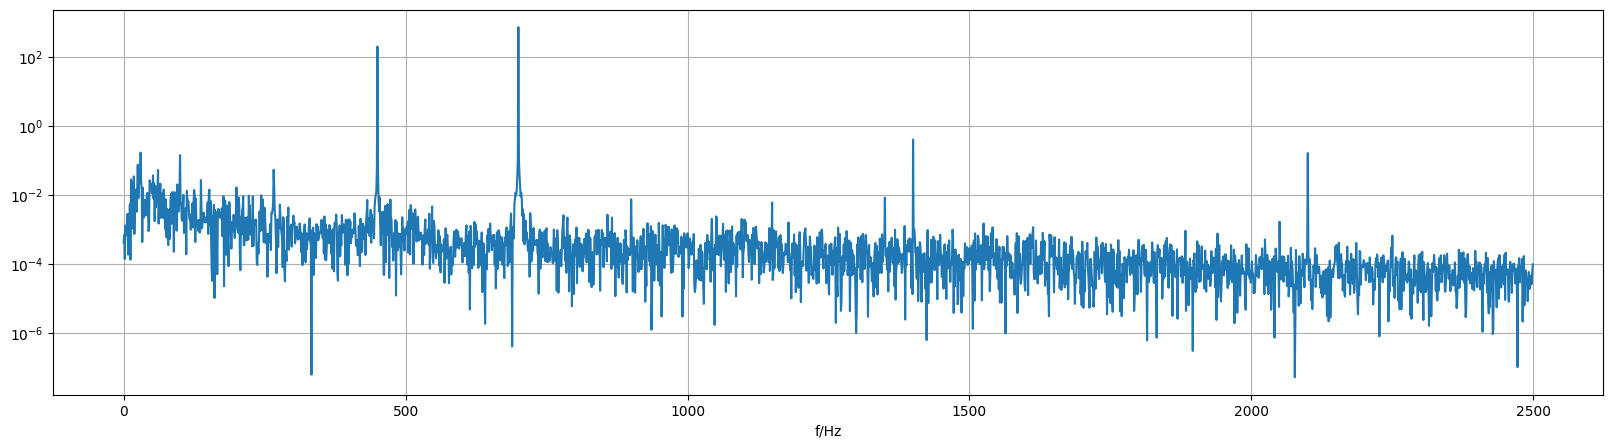

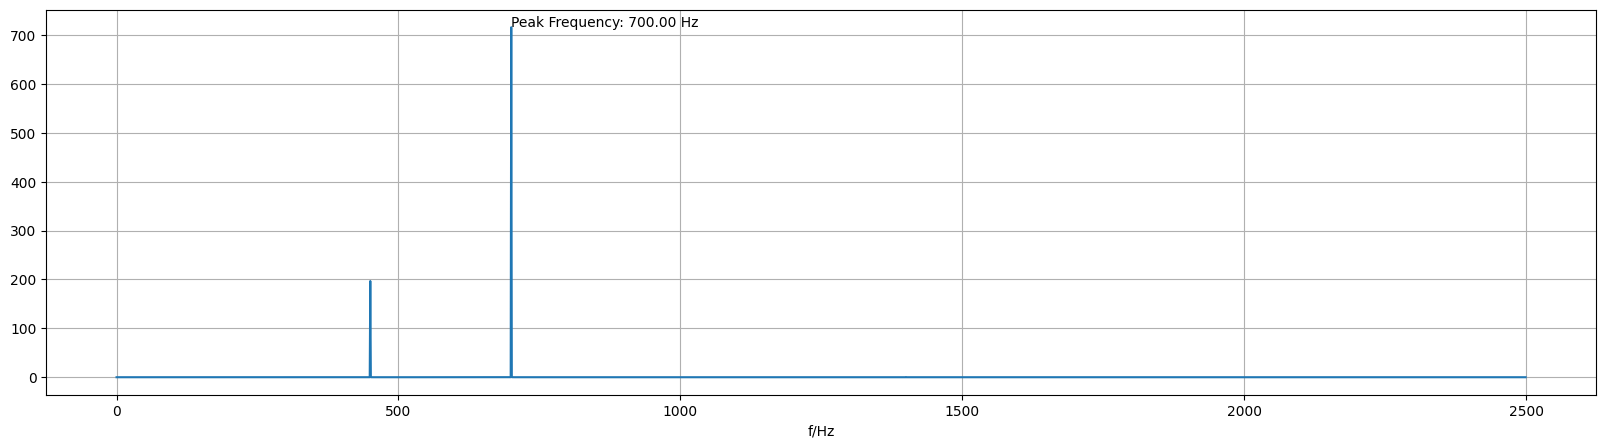

In [49]:
plt.figure(2, (20,5))
plt.plot(freqs[:ind],power_spectrum[:ind])
plt.yscale('log')
plt.xlabel('f/Hz')
plt.grid(True)
plt.show()

plt.figure(3, (20,5))
plt.plot(freqs[:ind],power_spectrum[:ind])
peak_frequency = freqs[np.argmax(power_spectrum)]
plt.annotate(f"Peak Frequency: {peak_frequency:.2f} Hz", xy=(peak_frequency, np.max(power_spectrum)))
plt.grid(True)
plt.xlabel('f/Hz')
plt.show()

In [50]:
freq_bands = [250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150, 4000, 5000, 6300, 8000]

In [51]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

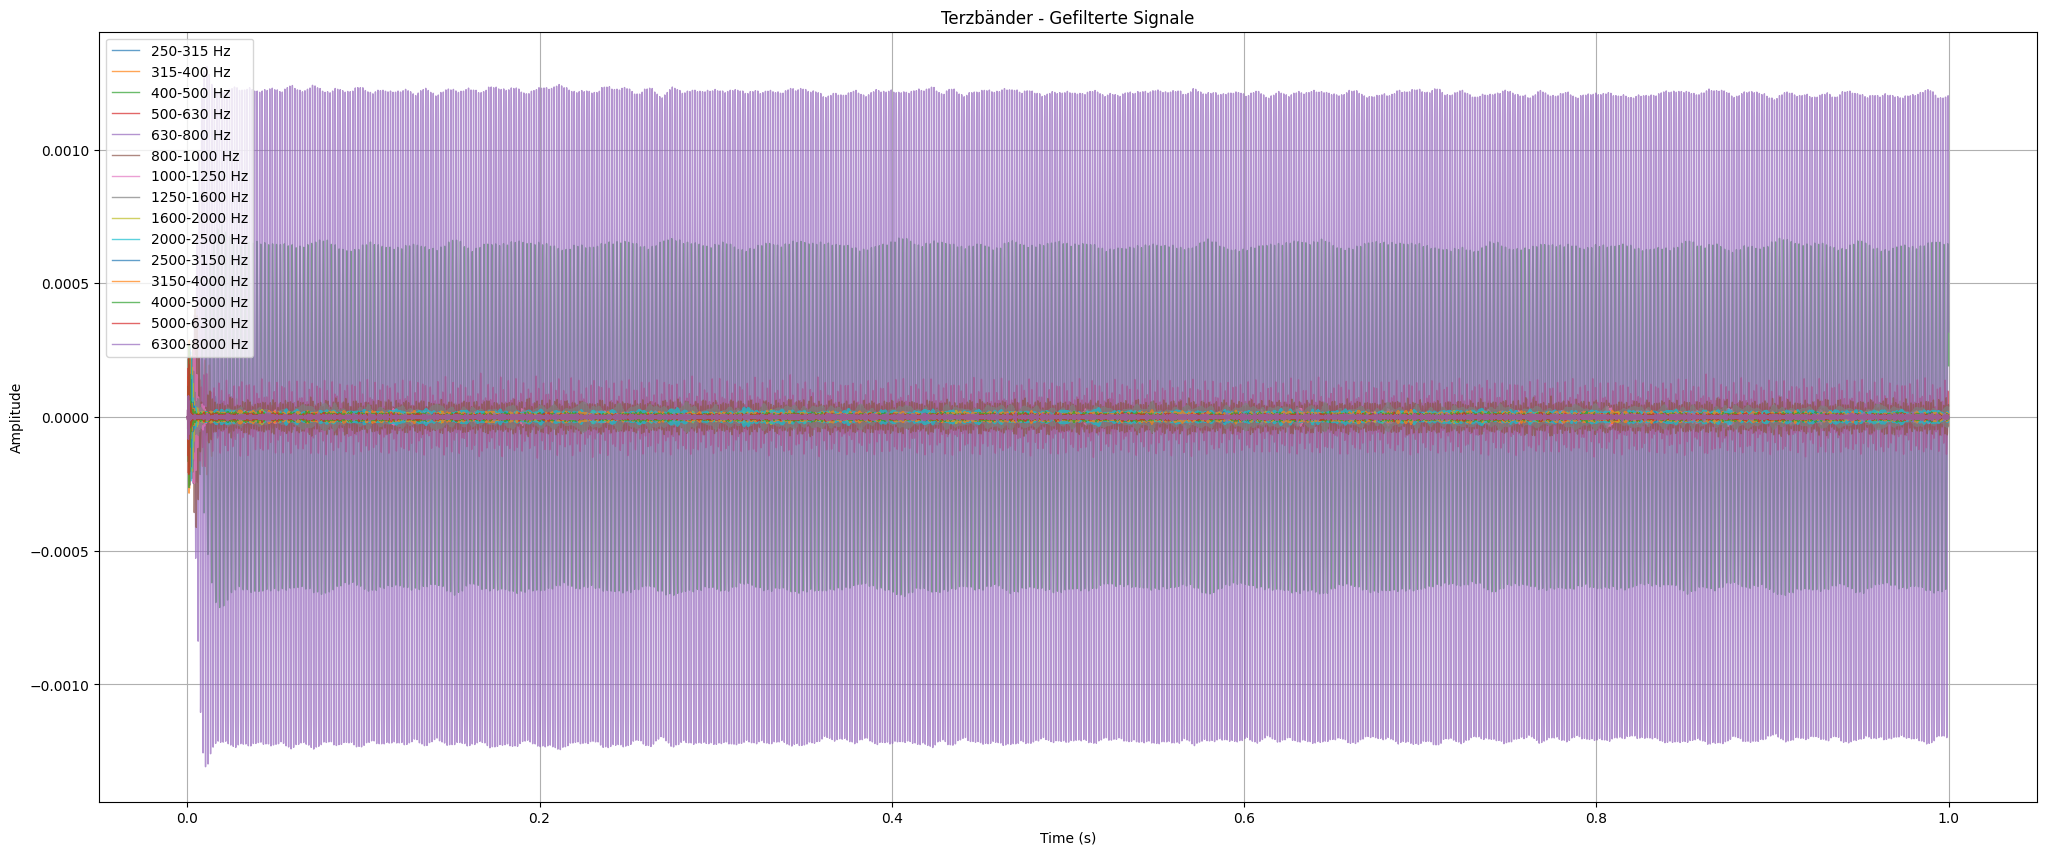

In [52]:
plt.figure(figsize=(25,10))

for i, band in enumerate(freq_bands[:-1]):
    lowcut = freq_bands[i]
    highcut = freq_bands[i+1]
    filtered_signal = bandpass_filter(signal[:, 0], lowcut, highcut, fs, order=4)

    plt.plot(t, filtered_signal, linewidth=1, label=f'{lowcut}-{highcut} Hz', alpha=0.7)  # Alpha für Transparenz

plt.title('Terzbänder - Gefilterte Signale')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

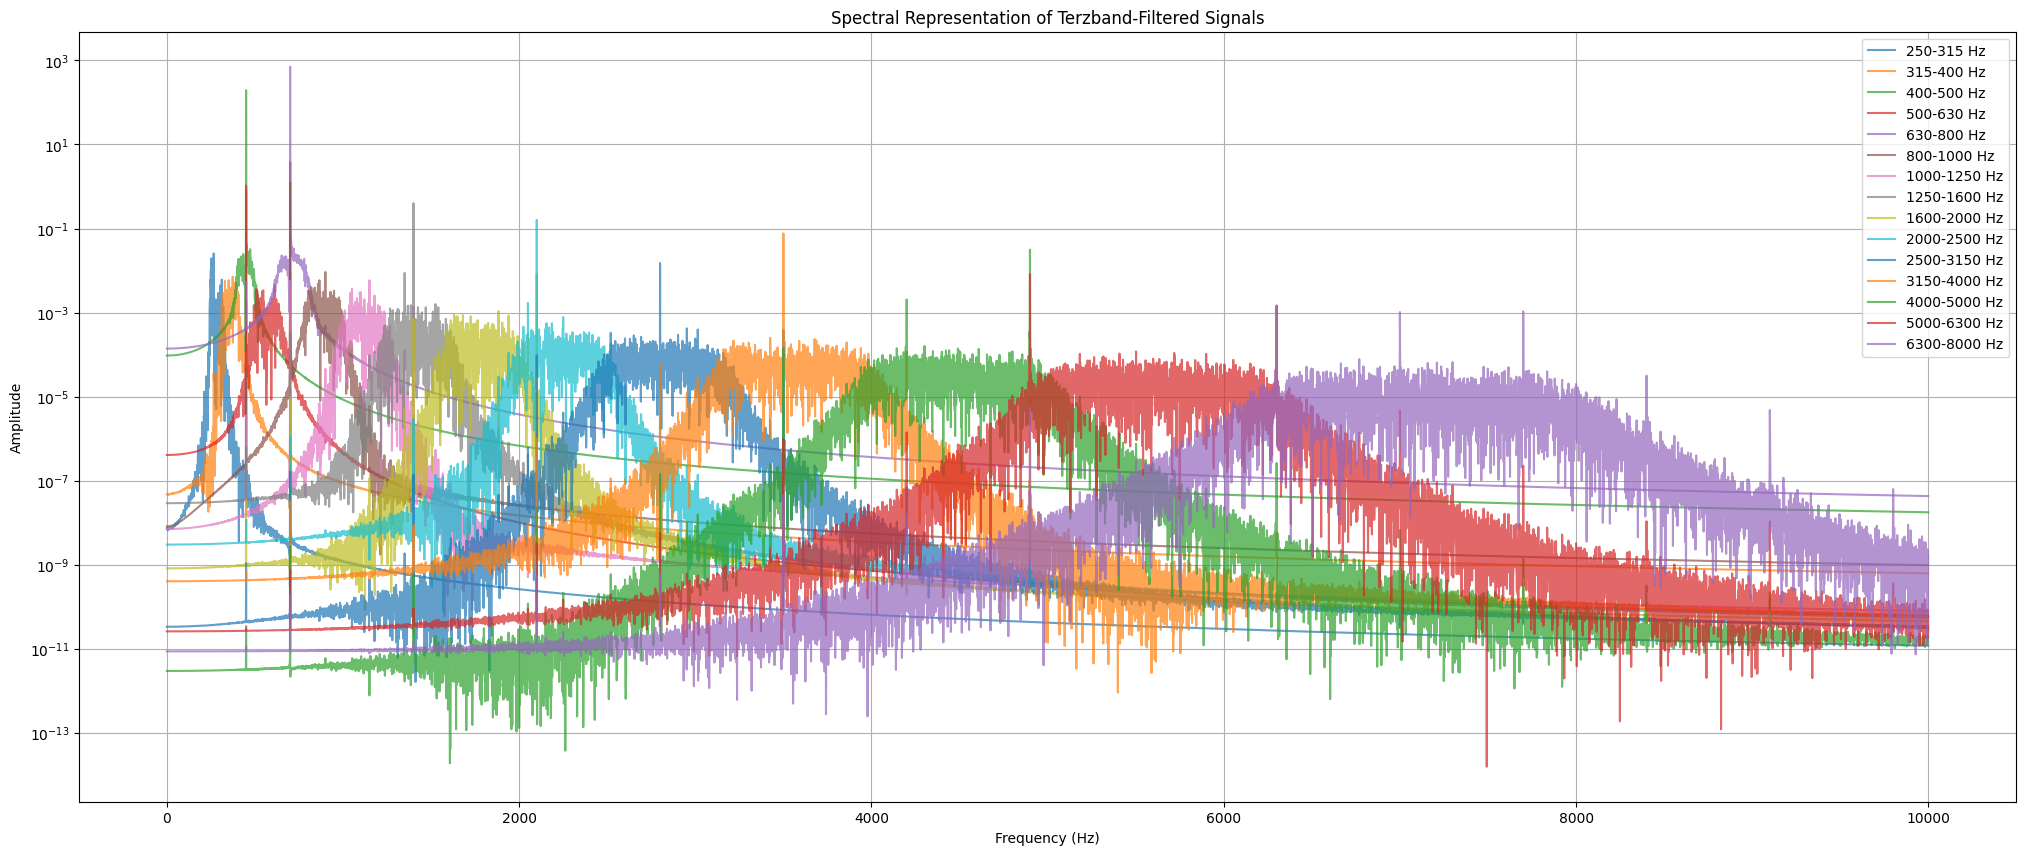

In [53]:
plt.figure(figsize=(25, 10))

ind = np.searchsorted(freqs, 10000)

for i, band in enumerate(freq_bands[:-1]):
    lowcut = freq_bands[i]
    highcut = freq_bands[i+1]
    filtered_signal = bandpass_filter(signal[:, 0], lowcut, highcut, fs, order=4)
    filtered_spectrum = np.fft.rfft(filtered_signal)
    filtered_power_spectrum = np.real(filtered_spectrum * filtered_spectrum.conjugate())
    freqs = np.fft.rfftfreq(filtered_signal.shape[0], d=df)
    plt.plot(freqs[:ind], filtered_power_spectrum[:ind], label=f'{lowcut}-{highcut} Hz', alpha=0.7)

plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectral Representation of Terzband-Filtered Signals')
plt.legend()
plt.grid(True)
plt.show()